# Unsupervised Anomaly Detection for High-Energy Physics Using VAEs
In this notebook, we perform anomaly detection using Variational Auto-Encoders in the context of high-energy physics.
We are training the model on "normal" data, which in this context refers to the Standard Model (SM) events. The goal is to learn a representation of these normal events such that when the model encounters an anomalous event (potentially New Physics), it can detect it based on reconstruction error or the learned latent space.
The key steps include:
- Data Loading and Preprocessing
- Model Training (using an autoencoder)
- Visualization using t-SNE for understanding the latent space
- Evaluation of Anomalies based on model predictions.

## Data Loading and Preprocessing

We begin by loading the dataset and performing necessary preprocessing steps. 
These steps include normalizing the data and splitting it into training and testing sets, 
which is essential for unsupervised learning tasks.


In [1]:
import os
import gc  # Garbage collector for memory management

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F


import optuna
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def normalize_data(data, min_vals=None, max_vals=None, num_classes=5):
    features = data[:, :, :-1]  # Extract features, exclude last column (particle type)
    particle_type_index = data[:, :, -1].astype(int)  # Last column as particle type index
    
    # Mask to identify valid rows (where particle_type_index != 0)
    valid_mask = (particle_type_index != 0)
    
    # Only consider non-zero rows for min/max calculation
    valid_features = features[valid_mask]
    
    # Ensure min_vals and max_vals are computed based on valid (non-zero) features
    if min_vals is None or max_vals is None:
        min_vals = valid_features.min(axis=0)
        max_vals = valid_features.max(axis=0)
    
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Avoid division by zero
    
    # Normalize the non-zero features
    normalized_features = np.zeros_like(features)
    normalized_features[valid_mask] = (features[valid_mask] - min_vals) / range_vals
    
    # Initialize with zeros for 4 one-hot encoded columns (for 4 particle types excluding padding)
    one_hot_particle_types = np.zeros((data.shape[0], data.shape[1], 4))  # Array for 4 one-hot columns

    # Generate one-hot encoding for 4 particle types (exclude padding, particle_type_index == 0)
    one_hot_encoded = np.eye(num_classes - 1)[particle_type_index[valid_mask] - 1]  # 4 one-hot columns

    # Assign the one-hot encoded particle types to the correct locations
    one_hot_particle_types[valid_mask] = one_hot_encoded  # Push the one-hot encoded vectors into the array

    # Combine normalized features with one-hot encoded particle types (3 continuous + 4 one-hot encoded = 7 columns)
    normalized_data = np.concatenate([normalized_features, one_hot_particle_types], axis=-1)
    
    # Now filter out the padded rows completely from the data
    non_padded_rows_mask = np.any(normalized_features != 0, axis=2)
    filtered_data = normalized_data[non_padded_rows_mask]
    
    return filtered_data, min_vals, max_vals


In [5]:
def create_datasets(bkg_file, signals_files, blackbox_file, events=None, test_size=0.2, val_size=0.2, input_shape=7, batch_size=64):
    # Step 1: Load and process BACKGROUND data (SM data)
    with h5py.File(bkg_file, 'r') as file:
        full_data = file['Particles'][:, :, :input_shape]
        np.random.shuffle(full_data)  # Shuffle the data
        if events:
            full_data = full_data[:events, :, :]  # Limit the number of events
    
    # Normalize background data
    full_data, bkg_min_vals, bkg_max_vals = normalize_data(full_data)
    
    # Step 2: Split the data into training, validation, and testing sets
    X_train, X_temp = train_test_split(full_data, test_size=test_size, shuffle=True)
    X_val, X_test = train_test_split(X_temp, test_size=val_size)
    
    # Clean up memory
    del full_data, X_temp
    gc.collect()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor)
    val_dataset = TensorDataset(X_val_tensor)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del X_train, X_val, X_train_tensor, X_val_tensor
    gc.collect()

    # Step 3: Load and process SIGNAL data (BSM data)
    bsm_data_list = []
    for signal_file in signals_files:
        with h5py.File(signal_file, 'r') as f:
            signal_data = f['Particles'][:, :, :input_shape]
            # Normalize signal data using background normalization parameters
            signal_data, _, _ = normalize_data(signal_data, min_vals=bkg_min_vals, max_vals=bkg_max_vals)
            bsm_data_list.append(signal_data)
    
    # Concatenate all BSM data
    bsm_data = np.concatenate(bsm_data_list, axis=0)
    
    # Convert BSM data to a PyTorch tensor
    bsm_tensor = torch.tensor(bsm_data, dtype=torch.float32)
    
    # Create TensorDataset and DataLoader for test data
    test_dataset = TensorDataset(bsm_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del bsm_data_list, bsm_data, bsm_tensor
    gc.collect()
    
    # Step 4: Load and process BLACKBOX data
    with h5py.File(blackbox_file, 'r') as f:
        blackbox_data = f['Particles'][:, :, :input_shape]
        # Normalize blackbox data using background normalization parameters
        blackbox_data, _, _ = normalize_data(blackbox_data, min_vals=bkg_min_vals, max_vals=bkg_max_vals)
    
    # Convert blackbox data to a PyTorch tensor
    blackbox_tensor = torch.tensor(blackbox_data, dtype=torch.float32)
    
    # Create TensorDataset and DataLoader for blackbox data
    blackbox_dataset = TensorDataset(blackbox_tensor)
    blackbox_loader = DataLoader(blackbox_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del blackbox_data, blackbox_tensor
    gc.collect()
    
    return train_loader, val_loader, test_loader, blackbox_loader

background_file = 'dataset/background_for_training.h5'
signal_files = [
    'dataset/Ato4l_lepFilter_13TeV_filtered.h5',
    'dataset/hChToTauNu_13TeV_PU20_filtered.h5',
    'dataset/hToTauTau_13TeV_PU20_filtered.h5',
    'dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5'
]
blackbox_file = 'dataset/BlackBox_background_mix.h5'

train_loader, val_loader, test_loader, blackbox_loader = create_datasets(
    bkg_file=background_file,
    signals_files=signal_files,
    blackbox_file=blackbox_file,
    events=200000,  # Process only the first 100,000 events
    test_size=0.2,
    val_size=0.2,
    input_shape=7,
    batch_size=64
)

In [5]:
# Function to print random samples from a DataLoader
def print_random_samples(data_loader, num_samples=5):
    # Retrieve one batch from the DataLoader
    data_iter = iter(data_loader)
    batch = next(data_iter)
    
    # Convert batch to a NumPy array for easier manipulation
    batch_np = batch[0].numpy() 
    
    # Randomly select a few samples from the batch
    indices = np.random.choice(range(batch_np.shape[0]), num_samples, replace=False)
    random_samples = batch_np[indices]
    
    # Iterate through the random samples and print
    for i, sample in enumerate(random_samples):
        print(f"Sample {i+1}:\n", sample, "\n")

In [6]:
# Display samples from each dataset
print("Training Data Random Samples:")
print(train_loader.dataset.tensors[0].shape)
print_random_samples(train_loader, num_samples=3)

Training Data Random Samples:
torch.Size([521820, 7])
Sample 1:
 [0.04218173 0.61930656 0.26533443 0.         0.         0.
 1.        ] 

Sample 2:
 [0.00863428 0.57888335 0.8116877  0.         0.         1.
 0.        ] 

Sample 3:
 [0.02102152 0.49998933 0.35261783 1.         0.         0.
 0.        ] 



In [7]:
def plot_particle_type_distribution(loader, title="Particle Type Distribution (One-Hot Encoded)"):
    """
    Plots the distribution of particle types (e.g., MET, electrons, muons, jets)
    across all events in the given DataLoader, based on one-hot encoded particle type data.
    
    Args:
    - loader: PyTorch DataLoader that contains particle data
    - title: Title of the plot
    """
    # Initialize counter for particle types (ignoring padding)
    particle_counter = {
        'MET': 0,
        'Electrons': 0,
        'Muons': 0,
        'Jets': 0
    }
    
    # Loop over batches in the DataLoader
    for data in loader:
        if isinstance(data, (list, tuple)): 
            data = data[0]  # Extract the actual data
        
        if data.ndim == 3:  # Shape (batch_size, seq_length, features)
            # Extract the one-hot encoded particle type (last 4 features, assuming 4 particle types)
            one_hot_particle_types = data[:, :, -4:]  # Adjusted for 4 particle types
        elif data.ndim == 2:  # Shape (batch_size, features)
            one_hot_particle_types = data[:, -4:]  # Adjusted for 4 particle types
        else:
            raise ValueError(f"Unsupported data dimension: {data.ndim}")
        
         
        # Sum across the batch dimension to get the total counts for each particle type
        total_counts = np.sum(one_hot_particle_types.cpu().numpy(), axis=0)
        
        # Update the particle counter (adjusted indices for 4 types)
        particle_counter['MET'] += total_counts[0]
        particle_counter['Electrons'] += total_counts[1]
        particle_counter['Muons'] += total_counts[2]
        particle_counter['Jets'] += total_counts[3]

    # Prepare data for plotting
    labels = list(particle_counter.keys())
    values = list(particle_counter.values())
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(title)
    plt.xlabel('Particle Type')
    plt.ylabel('Count')
    plt.show()


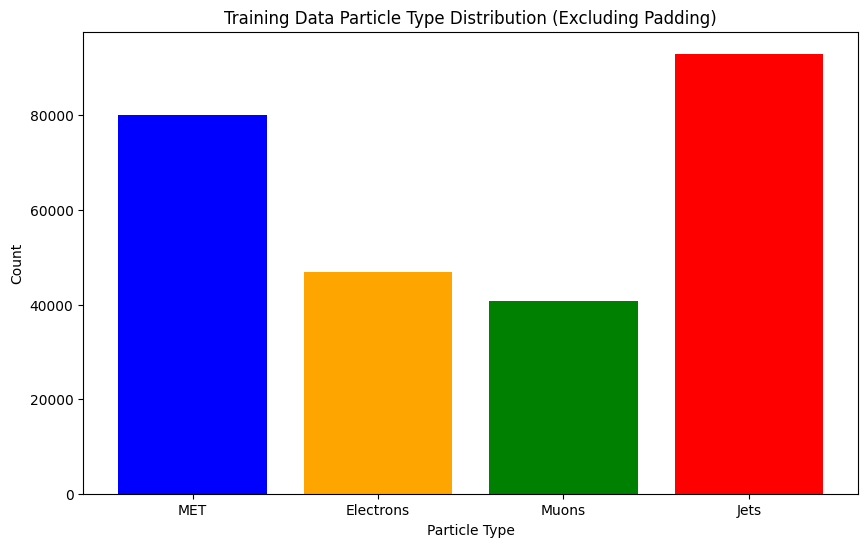

In [8]:
plot_particle_type_distribution(train_loader, title="Training Data Particle Type Distribution (Excluding Padding)")

In [8]:

def plot_distribution_from_loader(loader, title='Data Distribution', num_features=3):
    """
    Plots the distribution of each continuous feature from the DataLoader.

    Args:
    - loader: PyTorch DataLoader containing the data.
    - title: Title of the plot.
    - num_features: Number of continuous features to plot (default: 3 for pT, η, ϕ).
    """
    # Accumulate all the data from the DataLoader
    all_data = []
    for batch in loader:
        batch_data = batch[0].numpy()  # Assuming single input (X) in each batch
        all_data.append(batch_data)
    
    all_data = np.concatenate(all_data, axis=0)  # Combine batches into one array
    
    # Print the shape of all_data to debug
    print("All data shape:", all_data.shape)
    
    # Debugging: print the first few rows of the data
    print("First few rows of data:")
    print(all_data[:5])

    # Check if the data is 2D or 3D
    if all_data.ndim == 3:
        # 3D case (batch_size, seq_length, features)
        continuous_features = all_data[:, :, :num_features]  # Take the first `num_features` features
    elif all_data.ndim == 2:
        # 2D case (batch_size, features)
        continuous_features = all_data[:, :num_features]  # Take the first `num_features` features
    else:
        raise ValueError(f"Unsupported data dimension: {all_data.ndim}")
    
    # Plot the distribution of continuous features
    plt.figure(figsize=(15, 5))
    
    for i in range(num_features):
        plt.subplot(1, num_features, i + 1)
        plt.hist(continuous_features[:, i].flatten(), bins=50, alpha=0.7)
        plt.title(f'Feature {i+1}')
    
    plt.suptitle(f'{title} (Continuous Features)')
    plt.tight_layout()
    plt.show()


Plotting Training Data Distribution:
All data shape: (521820, 7)
First few rows of data:
[[0.08396799 0.49998933 0.7706598  1.         0.         0.
  0.        ]
 [0.02196044 0.49998933 0.43252742 1.         0.         0.
  0.        ]
 [0.05374239 0.49998933 0.08245946 1.         0.         0.
  0.        ]
 [0.04439364 0.38630632 0.4147036  0.         0.         1.
  0.        ]
 [0.04481674 0.49998933 0.7242299  1.         0.         0.
  0.        ]]


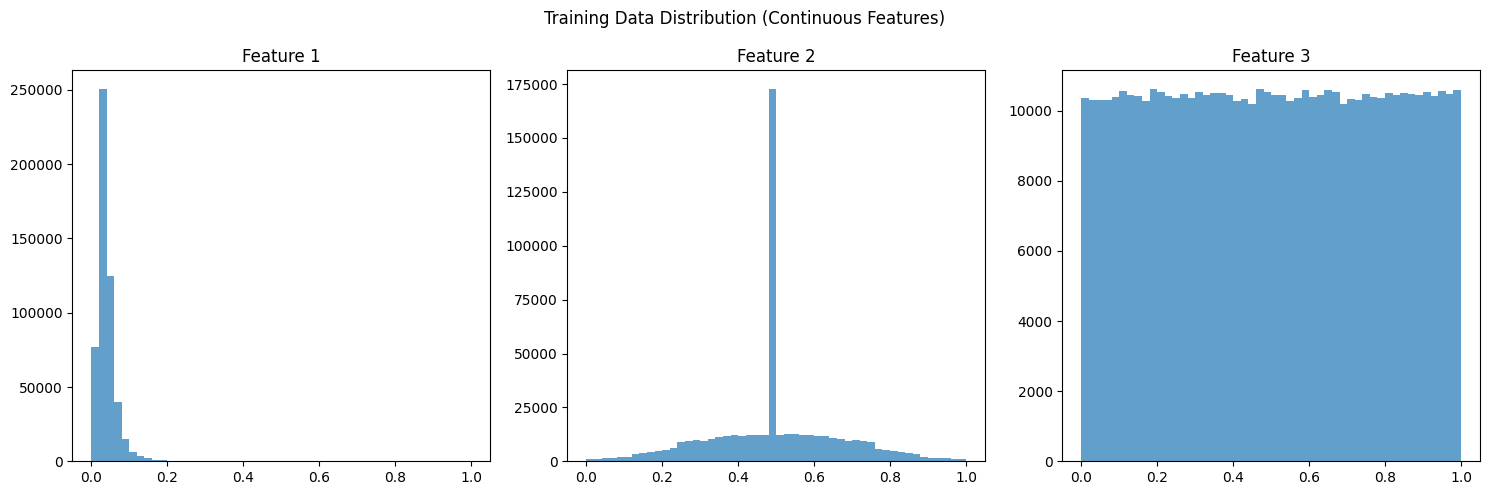

In [9]:
 # Plot distributions for training
print("Plotting Training Data Distribution:")
plot_distribution_from_loader(train_loader, title='Training Data Distribution')

## Model Training

In this section, we train an autoencoder model to learn the latent representation of the data. 
The model attempts to reconstruct the input data, and high reconstruction errors are 
considered indicative of anomalies.


In [6]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, latent_dim * 2)  # Output mu and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Normalize output
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Xavier Initialization Function
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [11]:
def loss_function(x, x_recon, mu, logvar, epoch, recon_loss_history, kld_weight_final, warmup_epochs):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')

    # KL divergence loss calculation
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Only start increasing KLD weight after warmup_epochs
    if epoch >= warmup_epochs:
        kld_weight = (epoch - warmup_epochs) / (num_epochs - warmup_epochs) * kld_weight_final
    else:
        kld_weight = 0  # No KLD contribution during warmup

    total_loss = recon_loss + kld_weight * kld_loss
    return total_loss, recon_loss, kld_loss


In [12]:
print(train_loader.dataset.tensors[0].shape)

torch.Size([521820, 7])


Hyperparameter Tuning using Optuna

In [116]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    latent_dim = trial.suggest_int('latent_dim', 5, 50)  # Latent dimension range
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # LR range
    kld_weight_final = trial.suggest_uniform('kld_weight_final', 0.001, 0.1)  # Final weight for KLD
    warmup_epochs = trial.suggest_int('warmup_epochs', 10, 50)  # Warm-up period

    # Initialize VAE model and optimizer
    vae = VAE(input_dim, latent_dim).to(device)
    vae.apply(weights_init)
    optimizer = optim.AdamW(vae.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    recon_loss_history = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in range(num_epochs):
        vae.train()
        train_loss = 0

        for batch in train_loader:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]  # Extract the input data, assuming it's the first element of the tuple/list
            batch = batch.view(batch.size(0), -1).to(device)  # Flatten the input and move to the device

            optimizer.zero_grad()

            x_recon, mu, logvar = vae(batch)
            total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar, epoch, recon_loss_history, kld_weight_final, warmup_epochs)
            total_loss.backward()
            train_loss += total_loss.item()
            optimizer.step()


        # Append the latest reconstruction loss to the history
        if recon_loss_history:
            recon_loss_history.append(recon_loss.item())

        # Validation step
        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)):
                    batch = batch[0]  # Extract the input data
                batch = batch.view(batch.size(0), -1).to(device)  # Flatten the input and move to the device

                x_recon, mu, logvar = vae(batch)
                total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar, epoch, recon_loss_history, kld_weight_final, warmup_epochs)
                val_loss += total_loss.item()

        average_val_loss = val_loss / len(val_loader.dataset)

        # Save best validation loss
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss

    return best_val_loss

# Use Optuna to search for the best hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize the validation loss
study.optimize(objective, n_trials=20)  # Perform 20 trials to search for the best parameters

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Retrieve the best trial
best_trial = study.best_trial
print("Best trial: ", best_trial)

[I 2024-09-08 21:10:36,607] A new study created in memory with name: no-name-09059fe2-1a73-4da3-9bce-1e7f03d6a41a
/tmp/ipykernel_78321/3810002565.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)  # LR range
/tmp/ipykernel_78321/3810002565.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  kld_weight_final = trial.suggest_uniform('kld_weight_final', 0.001, 0.1)  # Final weight for KLD
[I 2024-09-08 21:18:53,271] Trial 0 finished with value: 0.00013213868548808127 and parameters: {'latent_dim': 36, 'learning_rate': 8.516376133726326e-05, 'kld_weight_final': 0.010525954603977879, 'warmup_epochs': 47}. Best is trial 0 

Best hyperparameters:  {'latent_dim': 45, 'learning_rate': 0.0002147544248683393, 'kld_weight_final': 0.09330828839413902, 'warmup_epochs': 46}
Best trial:  FrozenTrial(number=9, state=TrialState.COMPLETE, values=[7.156719260597915e-05], datetime_start=datetime.datetime(2024, 9, 8, 22, 15, 46, 533367), datetime_complete=datetime.datetime(2024, 9, 8, 22, 22, 55, 83329), params={'latent_dim': 45, 'learning_rate': 0.0002147544248683393, 'kld_weight_final': 0.09330828839413902, 'warmup_epochs': 46}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'latent_dim': IntDistribution(high=50, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'kld_weight_final': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'warmup_epochs': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=9, value=None)


Start Training Process based on the best trial parameter values:

In [7]:
# Training parameters
input_dim = 7  # 7 features
latent_dim = 45  # Updated latent space dimension based on Optuna search
learning_rate = 0.0002147544248683393  # Updated learning rate from Optuna
num_epochs = 200
warmup_epochs = 46  # Updated warm-up period for KL loss based on Optuna
kld_weight_final = 0.001 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(input_dim, latent_dim).to(device)
vae.apply(weights_init)

optimizer = optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Parameters to control the ramp-up
start_kld_epoch = 10  # Start introducing KLD only after this epoch
reconstruction_loss_threshold = 0.1  # Start KLD only if reconstruction loss falls below this threshold


In [8]:
def loss_function(x, x_recon, mu, logvar, epoch=None, recon_loss_history=None, kld_weight_final=0.01, start_kld_epoch=10, reconstruction_loss_threshold=0.1):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')

    # KL divergence loss calculation
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # If we are in testing mode (no epoch or recon_loss_history), use fixed KLD weight
    if epoch is None or recon_loss_history is None:
        kld_weight = kld_weight_final  # Fixed KLD weight for testing
    else:
        # Sigmoid-based gradual introduction of KLD weight during training
        if epoch >= start_kld_epoch and recon_loss_history[-1] <= reconstruction_loss_threshold:
            # Convert to tensor before applying torch.exp
            kld_weight = kld_weight_final / (1 + torch.exp(-0.2 * torch.tensor(float(epoch - start_kld_epoch), device=x.device)))
        else:
            kld_weight = 0.0  # No KLD until reconstruction loss improves sufficiently

    total_loss = recon_loss + kld_weight * kld_loss
    return total_loss, recon_loss, kld_loss


In [9]:
# Training loop
recon_loss_history = []

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    for batch in train_loader:
        batch = batch[0] if isinstance(batch, (list, tuple)) else batch
        batch = batch.view(batch.size(0), -1).to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar, epoch, recon_loss_history)
        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Train Loss: {average_train_loss:.4f}, Recon Loss: {recon_loss.item():.4f}, KLD Loss: {kld_loss.item():.4f}')

    # Append the latest reconstruction loss to the history
    recon_loss_history.append(recon_loss.item())

    # Validation step
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch[0]
            batch = batch.view(batch.size(0), -1).to(device)
            x_recon, mu, logvar = vae(batch)
            total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar, epoch, recon_loss_history)
            val_loss += total_loss.item()

    average_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch+1}, Validation Loss: {average_val_loss:.4f}, Recon Loss: {recon_loss.item():.4f}, KLD Loss: {kld_loss.item():.4f}')
    
model_save_path = f"models/vae_v1.pth"
torch.save(vae.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1, Train Loss: 0.0160, Recon Loss: 0.0142, KLD Loss: 3346.6274
Epoch 1, Validation Loss: 0.0004, Recon Loss: 0.0111, KLD Loss: 5817.7002
Epoch 2, Train Loss: 0.0004, Recon Loss: 0.0035, KLD Loss: 4214.4727
Epoch 2, Validation Loss: 0.0002, Recon Loss: 0.0059, KLD Loss: 6705.4272
Epoch 3, Train Loss: 0.0002, Recon Loss: 0.0032, KLD Loss: 3983.6936
Epoch 3, Validation Loss: 0.0000, Recon Loss: 0.0013, KLD Loss: 7478.8457
Epoch 4, Train Loss: 0.0001, Recon Loss: 0.0014, KLD Loss: 4776.9004
Epoch 4, Validation Loss: 0.0001, Recon Loss: 0.0022, KLD Loss: 8298.3730
Epoch 5, Train Loss: 0.0001, Recon Loss: 0.0021, KLD Loss: 5135.5908
Epoch 5, Validation Loss: 0.0000, Recon Loss: 0.0008, KLD Loss: 9133.4766
Epoch 6, Train Loss: 0.0001, Recon Loss: 0.0014, KLD Loss: 6077.6191
Epoch 6, Validation Loss: 0.0000, Recon Loss: 0.0010, KLD Loss: 9908.0098
Epoch 7, Train Loss: 0.0001, Recon Loss: 0.0016, KLD Loss: 6679.5010
Epoch 7, Validation Loss: 0.0000, Recon Loss: 0.0007, KLD Loss: 10677.564

In [138]:
# Load the saved model
model_load_path = "models/vae_v5.pth"  
vae.load_state_dict(torch.load(model_load_path, map_location=device))
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=128, out_features=90, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=7, bias=True)
    (5): Sigmoid()
  )
)

## Model Evaluation

We evaluate the model by analyzing its ability to reconstruct normal data points. 
High reconstruction error indicates potential anomalies in the dataset.


Sample shape: (5, 7)
Reconstruction shape: (5, 7)


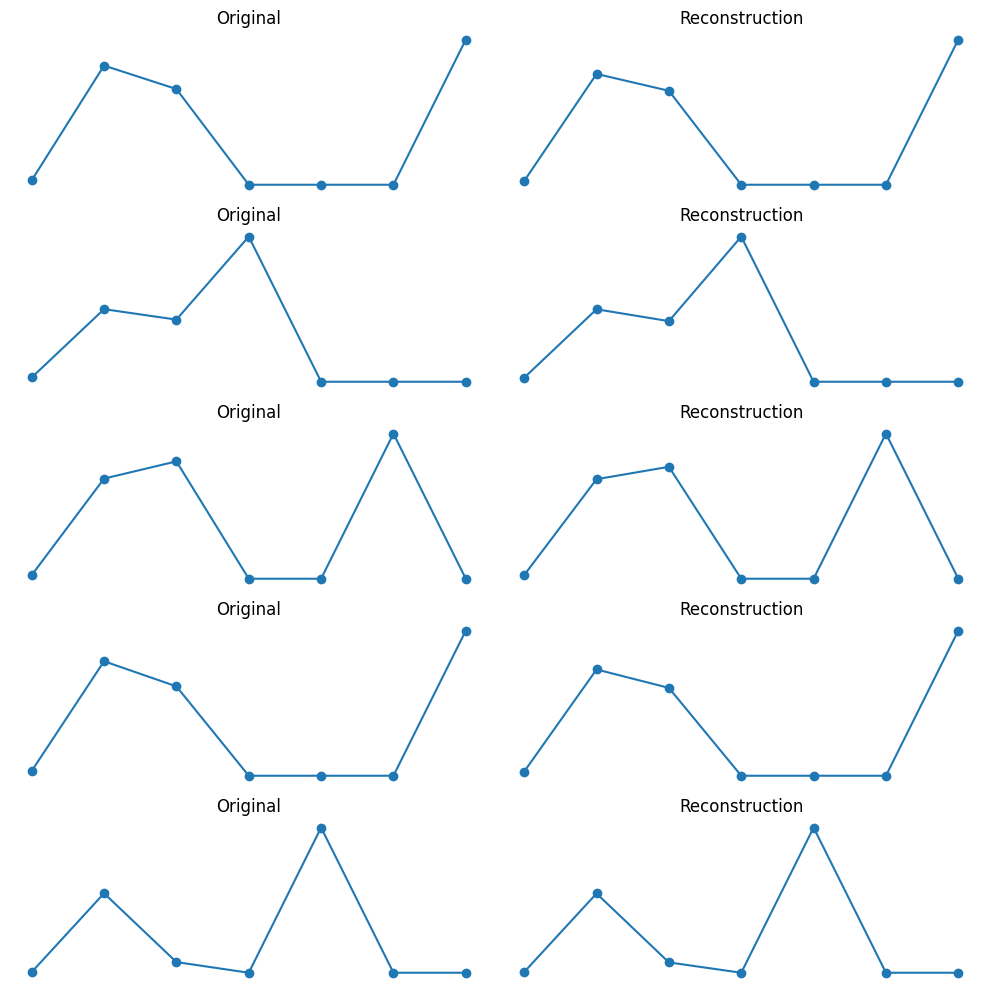

In [24]:

def visualize_reconstructions(vae, data_loader, device, num_samples=5):
    vae.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)
            batch = batch.view(batch.size(0), -1) # Flatten the input
            x_recon, _, _ = vae(batch)
            
            # Select a few samples
            samples = batch[:num_samples]
            reconstructions = x_recon[:num_samples]
            break  # We only need one batch for visualization

    # Convert tensors to numpy arrays
    samples_np = samples.cpu().numpy()
    reconstructions_np = reconstructions.cpu().numpy()

    # Print shapes for debugging
    print(f'Sample shape: {samples_np.shape}')
    print(f'Reconstruction shape: {reconstructions_np.shape}')

    # Plot input vectors and reconstructions
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
    for i in range(num_samples):
        # Plot original sample
        axes[i, 0].plot(samples_np[i], marker='o')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Plot reconstruction
        axes[i, 1].plot(reconstructions_np[i], marker='o')
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_reconstructions(vae, val_loader, device)


Sample shape: (5, 7)
Reconstruction shape: (5, 7)


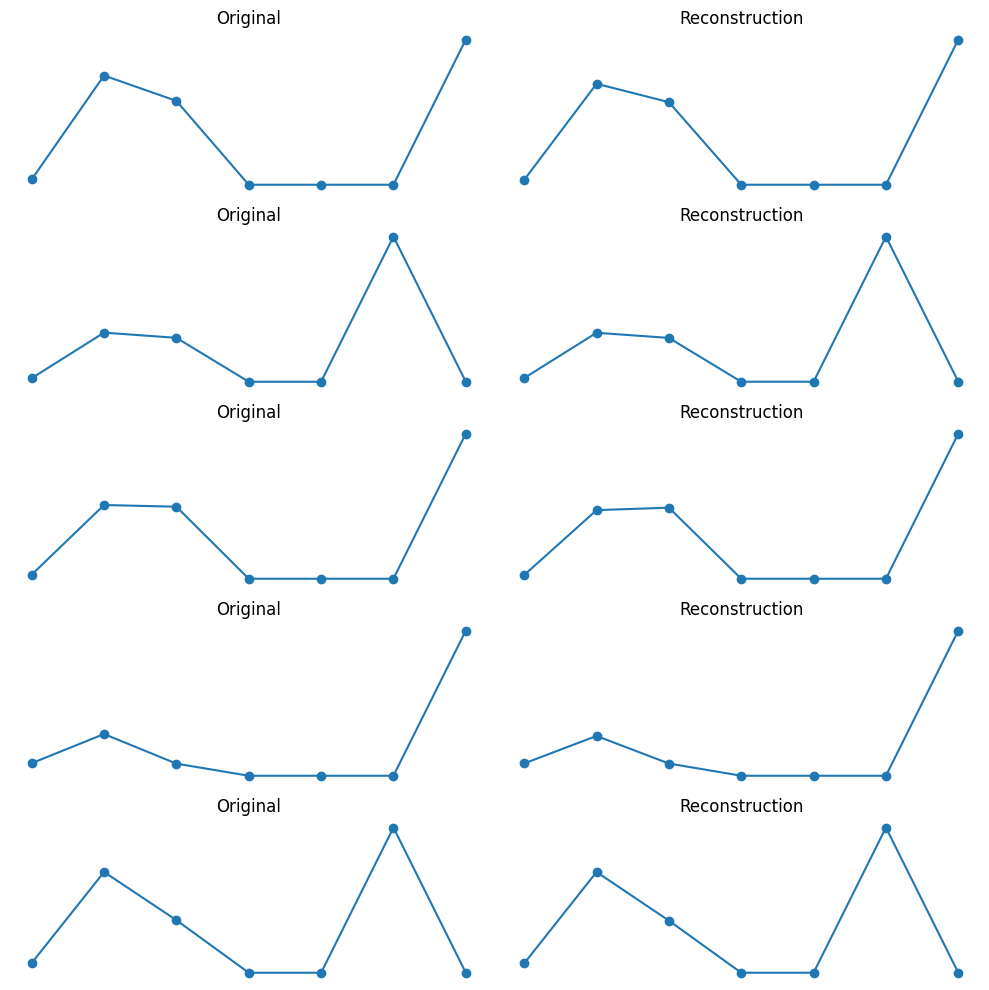

In [25]:
visualize_reconstructions(vae, train_loader, device)


In [26]:
# Testing loop
vae.eval()
test_loss = 0
recon_loss_total = 0
kld_loss_total = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].view(batch[0].size(0), -1).to(device)
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
        test_loss += total_loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
    
    average_test_loss = test_loss / len(test_loader.dataset)
    average_recon_loss = recon_loss_total / len(test_loader.dataset)
    average_kld_loss = kld_loss_total / len(test_loader.dataset)
    print(f' Test Loss: {average_test_loss:.4f}, Recon Loss: {average_recon_loss:.4f}, KLD Loss: {average_kld_loss:.4f}')

 Test Loss: 1.4796, Recon Loss: 0.0012, KLD Loss: 147.8497


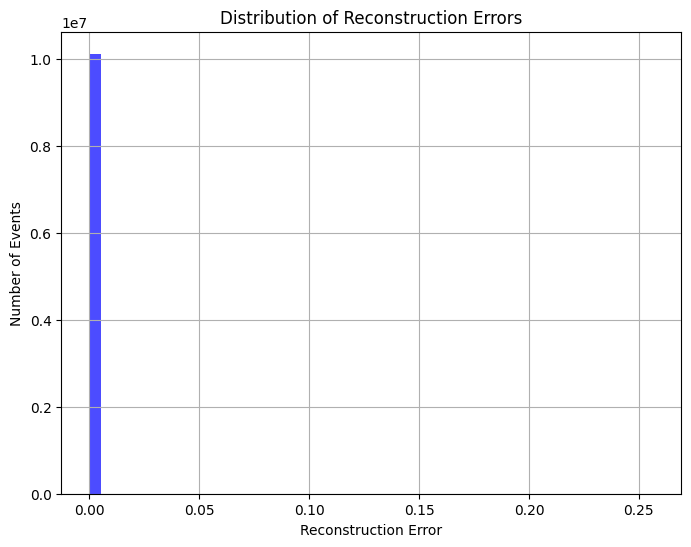

In [27]:
def plot_reconstruction_error(test_loader, vae, device):
    vae.eval()
    recon_errors = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].view(batch[0].size(0), -1).to(device)
            x_recon, mu, logvar = vae(batch)
            recon_loss = F.mse_loss(x_recon, batch, reduction='none').mean(dim=1)
            recon_errors.extend(recon_loss.cpu().numpy())
    
    plt.figure(figsize=(8, 6))
    plt.hist(recon_errors, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Events')
    plt.title('Distribution of Reconstruction Errors')
    plt.grid(True)
    plt.show()

plot_reconstruction_error(test_loader, vae, device)

Sample shape: (5, 7)
Reconstruction shape: (5, 7)


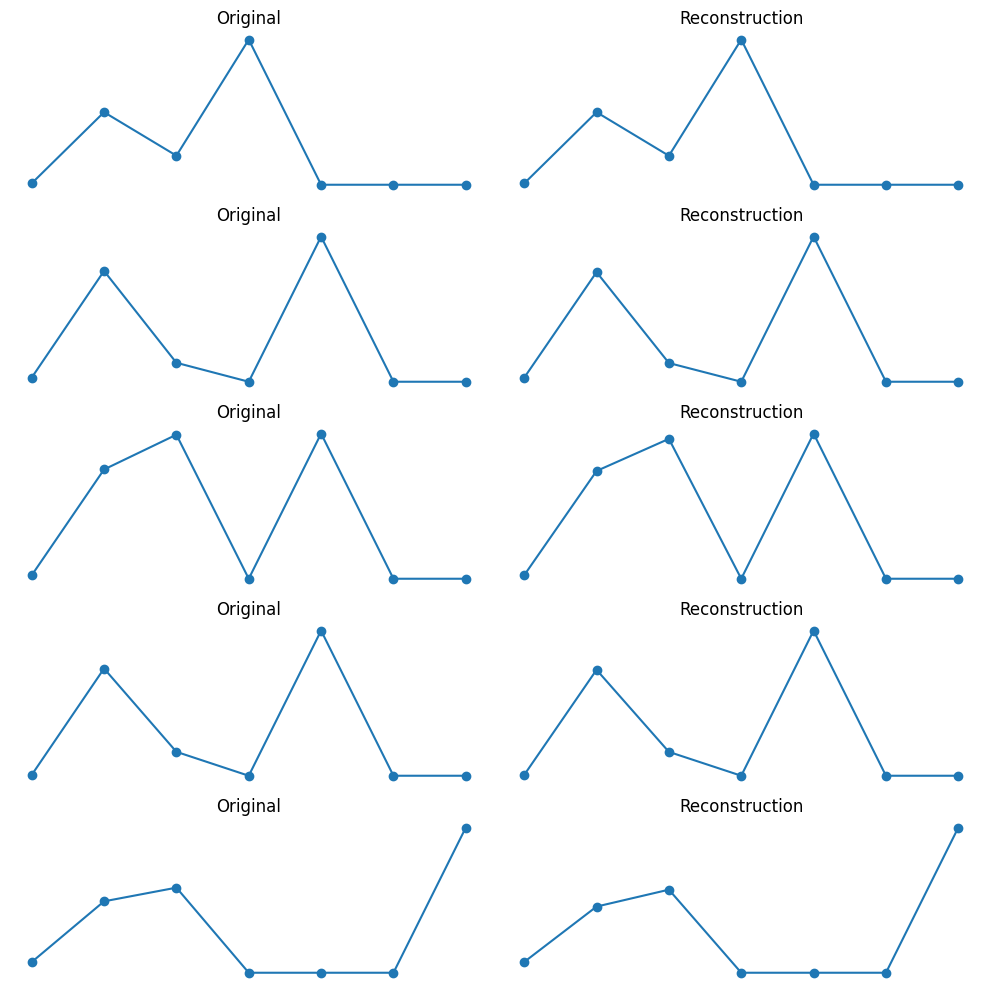

In [30]:
visualize_reconstructions(vae, test_loader, device)


In [32]:
# Evaluation on Blackbox data
vae.eval()
blackbox_loss = 0
recon_loss_total = 0
kld_loss_total = 0

with torch.no_grad():
    for batch in blackbox_loader:
        batch = batch[0].view(batch[0].size(0), -1).to(device)
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
        blackbox_loss += total_loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
    
    average_blackbox_loss = blackbox_loss / len(blackbox_loader.dataset)
    average_recon_loss = recon_loss_total / len(blackbox_loader.dataset)
    average_kld_loss = kld_loss_total / len(blackbox_loader.dataset)
    print(f' Blackbox Loss: {average_blackbox_loss:.4f}, Recon Loss: {average_recon_loss:.4f}, KLD Loss: {average_kld_loss:.4f}')

 Blackbox Loss: 1.3258, Recon Loss: 0.0009, KLD Loss: 132.4889


Sample shape: (5, 7)
Reconstruction shape: (5, 7)


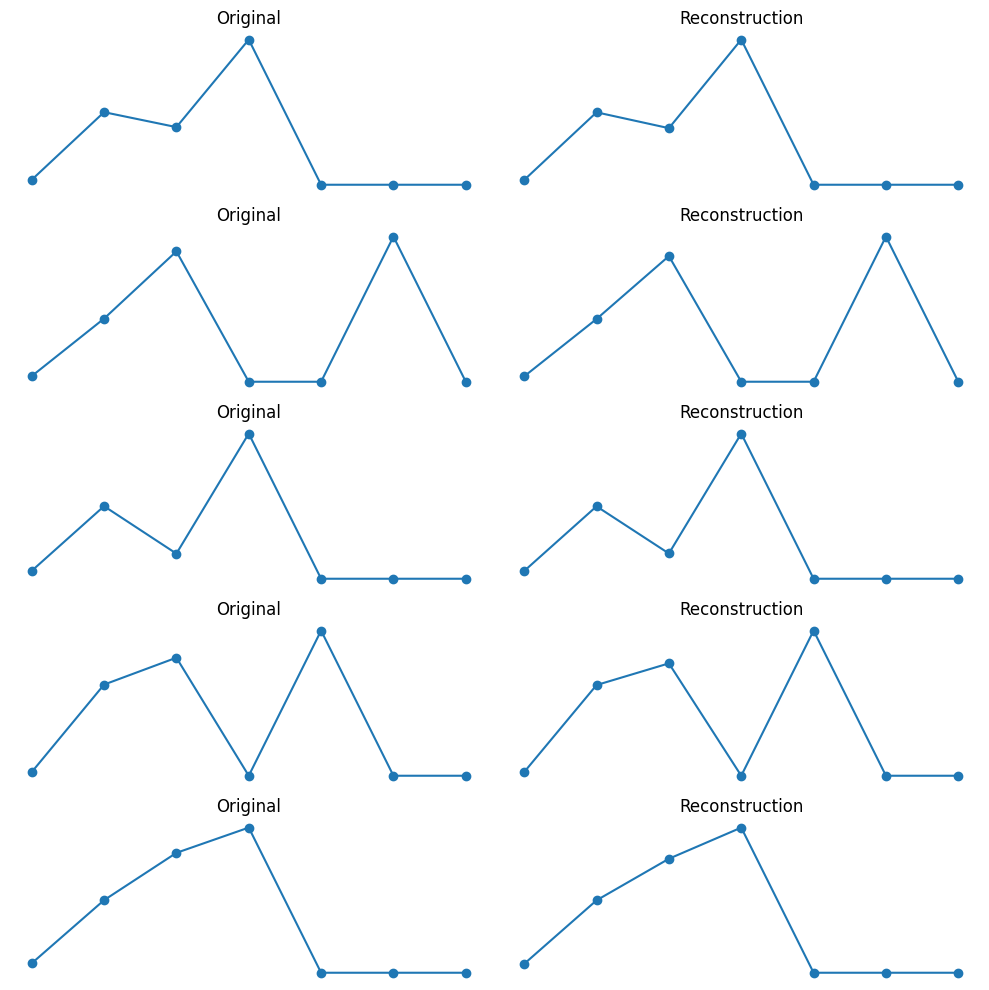

In [33]:
visualize_reconstructions(vae, blackbox_loader, device)


In [34]:
# Define the function to compute the reconstruction error
def compute_reconstruction_error(x, x_recon):
    return torch.mean((x - x_recon) ** 2, dim=1)

# Generate latent space representations and calculate reconstruction errors using blackbox_loader
vae.eval()  # Set the VAE to evaluation mode
reconstruction_errors = []
latent_representations = []
originals = []

# Define subsampling parameters
subsample_ratio = 0.5 
max_batches = 100  # Limit the number of batches processed
processed_batches = 0

In [35]:
# Process batches with subsampling
with torch.no_grad():
    for batch in blackbox_loader:
        # Stop early if max_batches is reached
        if processed_batches >= max_batches:
            break
        
        processed_batches += 1

        # Subsample within the batch
        if isinstance(batch, (tuple, list)):
            batch_data = batch[0]
        else:
            batch_data = batch
        
        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        # Apply subsampling within the batch
        num_samples = int(len(batch_data) * subsample_ratio)
        subsample_indices = np.random.choice(len(batch_data), num_samples, replace=False)
        batch_data = batch_data[subsample_indices]

        # Move data to device
        batch_data = batch_data.to(device)

        # Perform forward pass
        x_recon, mu, logvar = vae(batch_data)

        # Calculate reconstruction error
        error = compute_reconstruction_error(batch_data, x_recon)

        # Store results
        reconstruction_errors.extend(error.cpu().numpy())
        latent_representations.extend(mu.cpu().numpy())
        originals.extend(batch_data.cpu().numpy())


In [36]:
# Convert lists to numpy arrays
reconstruction_errors = np.array(reconstruction_errors)
latent_representations = np.array(latent_representations)
originals = np.array(originals)


In [148]:
print(reconstruction_errors)

[0.18299574 0.18053986 0.16399817 ... 0.17694189 0.15623717 0.17577347]


## Latent Space Visualization using t-SNE

After training the model, we use t-SNE to project the high-dimensional latent space into a 
2D plane. The goal is to visually inspect clusters and detect any anomalies in the latent space.


In [37]:
# Define a threshold for anomalies (e.g., top 5% of reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies
anomalies = reconstruction_errors > threshold

In [38]:
# Apply PCA to reduce dimensions before t-SNE (optional but recommended for large datasets)
pca = PCA(n_components=5, random_state=42)
latent_pca = pca.fit_transform(latent_representations)

In [39]:
# Apply t-SNE to the PCA-reduced latent representations
tsne = TSNE(n_components=2, random_state=42, n_iter=500)  # Reduced iterations for speed
latent_tsne = tsne.fit_transform(latent_pca)

/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


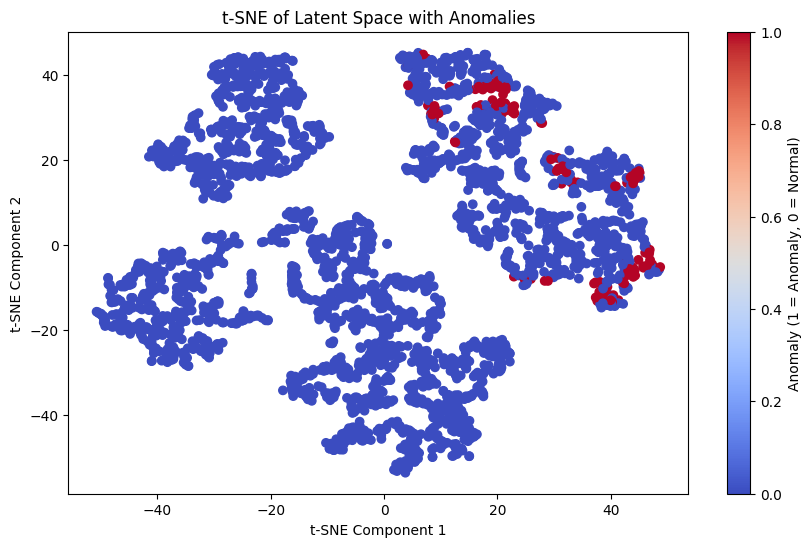

In [40]:
# Plot the t-SNE components, coloring by anomaly status
plt.figure(figsize=(10, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=anomalies, cmap='coolwarm', marker='o')
plt.colorbar(label='Anomaly (1 = Anomaly, 0 = Normal)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Latent Space with Anomalies')
plt.show()

In [43]:
anomalies_list = []
for batch in blackbox_loader:
    # Check if batch is a tuple or list and extract the data
    if isinstance(batch, (tuple, list)):
        original_batch = batch[0].to(device)  # Extract the actual data and move it to the correct device
    else:
        original_batch = batch.to(device)  # If it's already a tensor, move it directly to the device
    
    with torch.no_grad():
        reconstructed_batch, _, _ = vae(original_batch)
    
    # Calculate reconstruction errors
    reconstruction_errors = torch.mean(torch.abs(original_batch - reconstructed_batch), dim=1)
    
    # Mark anomalies based on reconstruction error threshold
    anomaly_labels = (reconstruction_errors > threshold).cpu().numpy()
    anomalies_list.append(anomaly_labels)

# Combine the anomaly labels into one array
anomalies_array = np.concatenate(anomalies_list)
